In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
import seaborn as sns
sns.set_style("dark")

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Read data

In [2]:
data = pd.read_csv('D:/tele2_data_hack/email_reports.csv')
print(data.shape)

(125938, 10)


In [3]:
data.head()

,SENDER_ID,SENDER_EMAIL,OPERATOR_ID,ACCEPTOR,SUBJECT,To.queue.time,agent.receive.time,treatment.end.time,CONTENT,ANSWERTEXT
0,token_7747,xxxx@yandex.ru,token_48,spb.vopros@tele2.ru,Обратная связь,2088-06-17 02:31:32,2088-06-18 19:48:26,2088-06-18 20:24:59,Тело письма\r\n\r\nMSISDN: +xxx xxx xx xx\r\nО...,"\r\n\r\nЗдравствуйте, xxxxx xxxxx xxxxx!\r\n\r..."
1,token_14226,xxxx@mail.ru,token_50,Saransk.Vopros@tele2.ru,Re[2]: Обратная связь,2088-06-17 02:31:52,2088-06-18 18:43:45,2088-06-18 18:58:43,\r\nвся необходимая информация отображена в ...,"Здравствуйте, xxxxx xxxxx xxxxx!\r\nБлагодарим..."
2,token_23942,xxxx@mail.ru,token_3,rostov.vopros@tele2.ru,Обратная связь,2088-06-17 02:33:14,2088-06-18 18:43:45,2088-06-18 18:47:06,Тело письма\r\n\r\nMSISDN: +xxx xxx xx xx\r\nО...,"\r\n\r\nЗдравствуйте, xxxxx xxxxx xxxxx!\r\nБл..."
3,token_18368,xxxx@mail.ru,token_53,krasnodar.vopros@tele2.ru,Обратная связь,2088-06-17 02:33:36,2088-06-18 19:49:10,2088-06-18 19:53:57,Тело письма\r\n\r\nMSISDN: +xxx xxx xx xx\r\nО...,"\r\n\r\nЗдравствуйте, xxxxx xxxxx xxxxx! ¦\r\n..."
4,token_21039,xxxx@mail.ru,token_34,kostroma.vopros@tele2.ru,Обратная связь,2088-06-17 02:33:56,2088-06-18 19:49:17,2088-06-18 19:59:48,"Тело письма\r\n\r\nОтметьте, в каком регионе В...","\r\n\r\nАлександр, доброго времени суток! ;)\r..."


# determine fraction of each problem 

In [4]:
# for training classifier use only letters for support 
print(data.shape)
data = data[data['CONTENT'].apply(lambda x: 'Тело письма' in str(x))].reset_index(drop=True)
print(data.shape)

(125938, 10)
(102898, 10)


### Get question from user and topic of this question 

In [5]:
def get_topic(x):
    ret = ''
    try:
        ret = x.split('Выберите тему обращения: ')[1].split('\r')[0]
    except:
        pass
    return ret

def get_question(x):
    ret = ''
    try:
        ret = x.split('Выберите тему обращения: ')[1].split('\r')[1].split('\nЗадайте ваш вопрос или опишите проблему: ')[1]
    except:
        pass
    return ret


data['topic'] = data['CONTENT'].apply(lambda x: get_topic(x))
data['question'] = data['CONTENT'].apply(lambda x: get_question(x))

### Statistics of topics 

In [6]:
temp = data[['topic','CONTENT']].groupby('topic').agg('count').reset_index()
temp = temp.rename_axis({'CONTENT':'Number of questions'},axis=1)
num_q = np.sum(temp['Number of questions'])
temp = temp[temp['Number of questions']>1200].reset_index(drop=True)

temp['Topic fraction'] = temp['Number of questions'] / num_q * 100
print('Most popular topics fraction: ', np.sum(temp['Topic fraction']), '%')

Most popular topics fraction:  97.50335283484615 %


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
  


In [7]:
temp.sort_values(by='Topic fraction', ascending=False)

,topic,Number of questions,Topic fraction
8,прочее,24434,23.745845
10,тарифыИУслуги,18770,18.241365
3,мобильныйИнтернет,15918,15.469688
6,подключенныеУслуги,9112,8.855371
2,личныйКабинет,7379,7.171179
9,роумингИЗонаОбслуживания,6732,6.542401
7,поступлениеПлатежейОшибочныеПлатежи,6045,5.874750
1,детализацияСчётаИлиЗвонков,5474,5.319831
0,блокировкаИРазблокировкаSimКарты,2412,2.344069
5,подключениеКTele2,2398,2.330463


In [8]:
most_freq_topics = list(temp['topic'])

In [9]:
# keep only freq topics 
data = data[data['topic'].apply(lambda x: x in most_freq_topics)].reset_index(drop=True)

In [10]:
def round_time(time, round_to):
    """roundTo is the number of minutes to round to"""
    rounded = time + datetime.timedelta(minutes=round_to/2.)
    rounded -= datetime.timedelta(minutes=rounded.minute % round_to,
                                  seconds=rounded.second,
                                  microseconds=rounded.microsecond)
    return rounded

In [11]:
data['To.queue.time'] = pd.to_datetime(data['To.queue.time'])
data['To.queue.time'] = data['To.queue.time'].apply(lambda x: round_time(x, 60))
data_time = data[['To.queue.time', 'topic', 'SENDER_ID']].groupby(['To.queue.time', 'topic']).agg('count').reset_index()
data_time = data_time.pivot(columns='topic', index='To.queue.time', values='SENDER_ID').reset_index().fillna(0)

# Show trends 

In [12]:
def trend_txt(text_line, n_steps):
    
    """""
    Display trends for given line of test. Show trend for last n_steps hours. Return plot with trend. 
    """""

    col_name = 'trend: ' + text_line
    data[col_name] = data['CONTENT'].apply(lambda x: 1*(text_line in str(x)))
    data_time_txt = data[['To.queue.time', col_name]].groupby(['To.queue.time']).agg('sum').reset_index()
    data_time_temp = data_time.copy()
    data_time_temp = pd.merge(data_time_temp, data_time_txt, how='left', on='To.queue.time')
    data_time_temp = data_time_temp[['To.queue.time', col_name]]
    
    series = np.array(data_time_temp[col_name])
    date_time = np.array(data_time_temp['To.queue.time'])
    print(col_name)

    plt.figure(figsize=(16,6))
    plt.title(col_name)
    plt.plot(date_time[-n_steps:], series[-n_steps:])
    plt.ylabel('Trend')
    plt.grid()
    plt.show()

trend: tele2


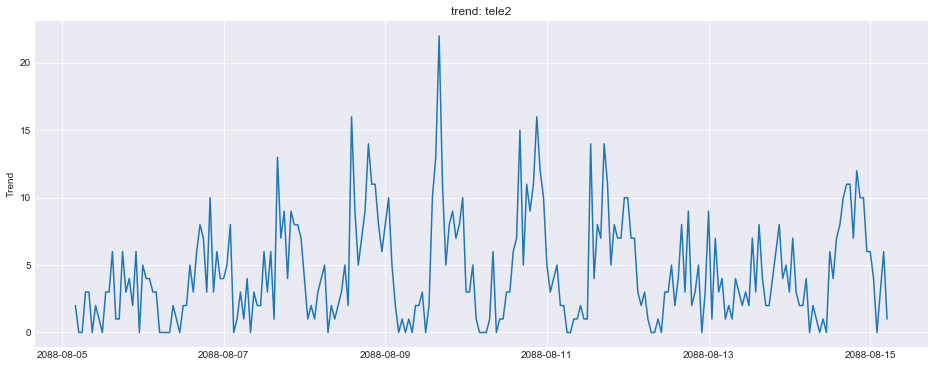

In [13]:
trend_txt('tele2', 240)

trend: не работает


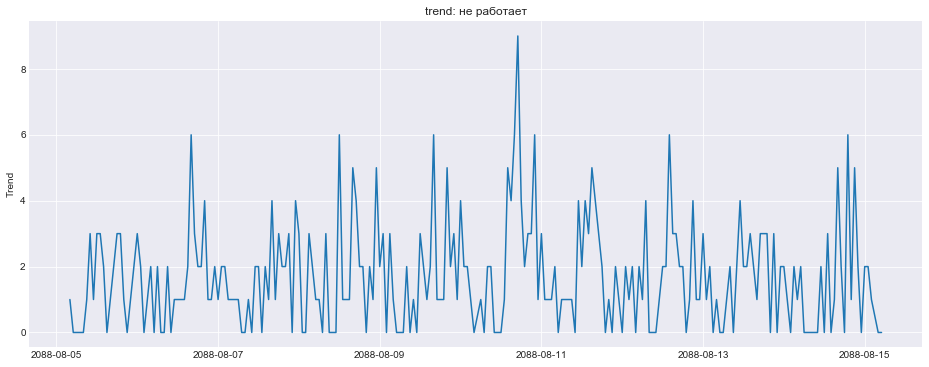

In [14]:
trend_txt('не работает', 240)

trend: плохо


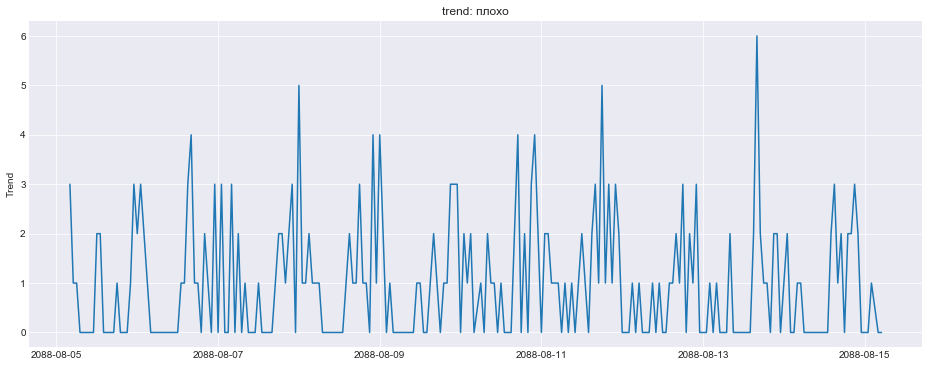

In [15]:
trend_txt('плохо', 240)

trend: хорошо


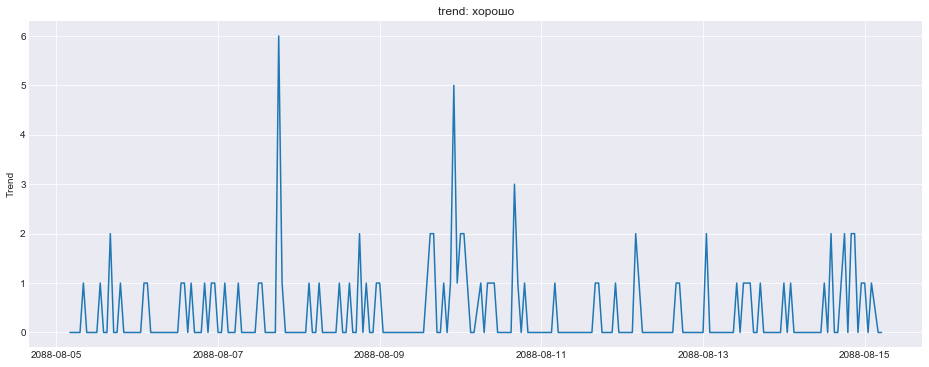

In [16]:
trend_txt('хорошо', 240)

trend: лаг


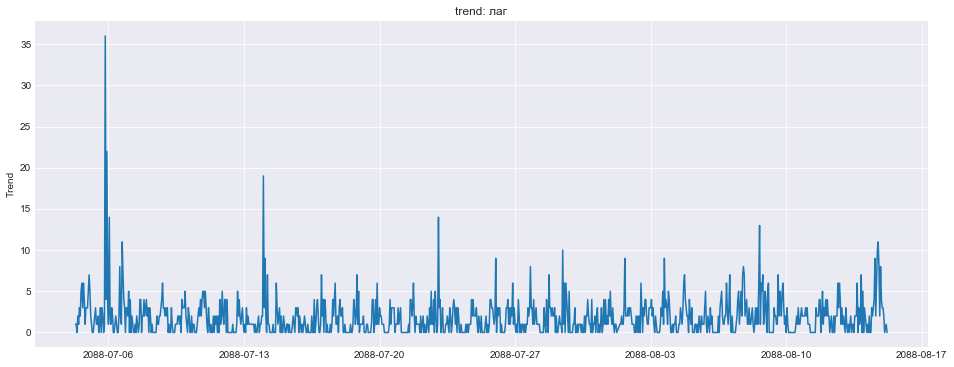

In [17]:
trend_txt('лаг', 999)

trend: ухожу


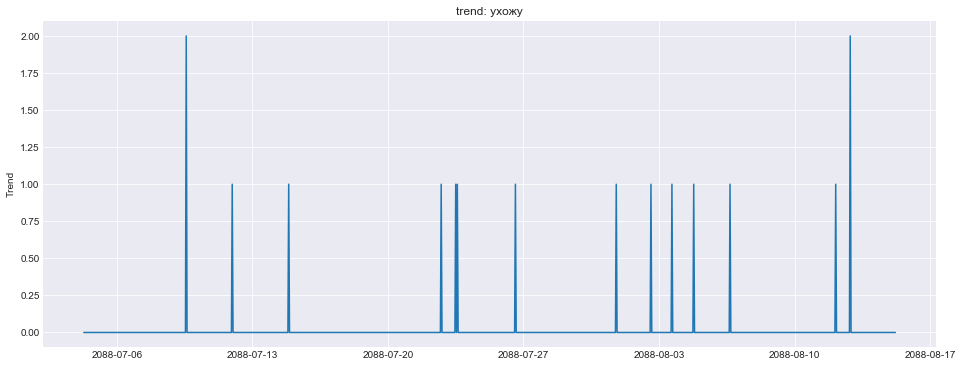

In [18]:
trend_txt('ухожу', 999)